This script presents final implementation for rectangular bounding boxes.

In [ ]:
# Loading all lib
import pandas as pd
import os
import glob
import cv2
import numpy as np
import json
import math

from keras import layers
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense,Resizing, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Masking, MaxPooling2D, Lambda,UpSampling2D, Reshape, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle
from sklearn.preprocessing import MaxAbsScaler
from random import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
#from keras_cv.models import YOLOv8
import keras_cv
from keras_cv.models import YOLOV8Backbone

Functions needed to load and process data. 

In [ ]:
##Usefull functions

#Getting all circular coordinates into one pd.DataFrame
def create_df(path_annotations_circle):
    # Finds and reads all CSV files in the given directory into a single DataFrame
    all_files = glob.glob(path_annotations_circle + "\\*.csv")
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

    # Extracts specific columns related to circular annotations
    df_circle = df[['name', 'c-x', 'c-y', 'radius']]

    return df_circle

# Define a function to get the maximum number of objects in one image based on a dataframe
def get_max_number(df_circle):
    # Group the dataframe by 'name', aggregate with count, sort by 'radius' in descending order
    value = df_circle.groupby('name').agg('count').sort_values('radius', ascending=False).max()[['radius']].tolist()
    
    # Return the first item from the list, which is the maximum count of a particular object
    return value[0]


# Define a function to get all circular bounding box coordinates into one list
def get_bbox_cords(df_circle):
    # Group the dataframe by 'name'
    gb = df_circle.groupby('name')    
    # Create a list of dataframes, one for each group
    gb = [gb.get_group(x) for x in gb.groups]

    list = []
    # Iterate over each group of dataframes
    for set_of_df in gb:
        lista = []
        # Loop to create a list of coordinates and radius values
        for i in range(18*3):
            # Check if the radius value is 'nan'
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                # Flatten and convert the columns 'c-x', 'c-y', and 'radius' to a list
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                # Calculate the number of zeros needed to make the list length 54
                number = 54 - len(lista)
                # Append zeros to the list
                a = [0]*number
                lista = lista + a
                break
        # Append the list of coordinates and radius values for each group to the main list
        list.append(lista)

    return list


# Define a function to convert bounding box coordinates to a dictionary
def get_bbox_cords_to_dict(df_circle):
    # Group the dataframe by 'name'
    gb = df_circle.groupby('name')    
    # Create a list of dataframes, one for each group
    gb = [gb.get_group(x) for x in gb.groups]

    # Initialize an empty dictionary
    dict = {}
    # Initialize an empty list
    list = []
    # Iterate over each group of dataframes
    for set_of_df in gb:
        # Extract the name and remove '.csv' from it
        name = (set_of_df['name'].values.tolist()[0].replace('.csv', ''))
        lista = []
        # Loop to create a list of coordinates and radius values
        for i in range(18*3):
            # Check if the radius value is 'nan'
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                # Flatten and convert the columns 'c-x', 'c-y', and 'radius' to a list
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                # Calculate the number of zeros needed to make the list length 54
                number = 54 - len(lista)
                # Append zeros to the list
                a = [0]*number
                lista = lista + a
                break
        # Add the list of coordinates and radius values for each group to the list
        list.append(lista)
        # Update the dictionary with the name as the key and the coordinates list as the value
        dict.update({name:lista})

    return dict


# Define a function to get image data from a specified directory
def get_image_data(imagespath):
    # Use glob to find all .png files in the specified path
    path = glob.glob(imagespath + '\\*.png')
    # Read each image using OpenCV and store them in a list
    images = [cv2.imread(file) for file in path]
    return images



# Define a function to apply a threshold and split predicted data into a list of lists, each containing three coordinates
def apply_threshold_and_split_pred(trainprediction, thresh):
    # Initialize an empty list for the final prediction
    prediction = []
    # Initialize a list to temporarily store groups of three coordinates
    three_coord_list = []
    # Iterator to keep track of the number of elements added to 'three_coord_list'
    iter = 0
    # Copy the prediction data to a new variable
    prediction_threshold = trainprediction

    # Apply the threshold to the prediction data
    for i in range(len(prediction_threshold[0])):
        if prediction_threshold[0][i] < thresh:
            prediction_threshold[0][i] = 0

    # Split the thresholded data into groups of four coordinates
    for elem in prediction_threshold[0]:
        if iter < 4:
            # Add element to the current group if less than 4 elements are added
            three_coord_list.append(elem)
            iter += 1
        else:
            # Reset iterator, add the current group to the final prediction list, and start a new group
            iter = 1
            prediction.append(three_coord_list)
            three_coord_list = [elem]
    # Add the last group to the final prediction list
    prediction.append(three_coord_list)

    return prediction


# Define a function to split an original image data into a list of lists, each containing three coordinates
def split_origin(origin_img):
    # Initialize an empty list for the split data
    origin = []
    # Initialize a list to temporarily store groups of three coordinates
    three_coord_list = []
    # Iterator to keep track of the number of elements added to 'three_coord_list'
    iter = 0

    # Iterate through each element in the original image data
    for elem in origin_img:
        if iter < 4:
            # Add element to the current group if less than 3 elements are added
            three_coord_list.append(elem)
            iter += 1
        else:
            # Reset iterator, add the current group to the final list, and start a new group
            iter = 1
            origin.append(three_coord_list)
            three_coord_list = [elem]
    # Add the last group to the final list
    origin.append(three_coord_list)

    return origin


# Define a function to draw circles on an image using matplotlib
def draw_circle(ax, Color, coords):
    # Iterate through each set of coordinates
    for elem in coords:
        # Extract width and height from the coordinates
        w = float(elem[2])
        h = float(elem[3])
        # Calculate the x and y position of the circle's lower-left corner
        x = float(elem[0]) - w/2
        y = float(elem[1]) - h/2
        # Create a rectangle (circles in the context) with the calculated dimensions and color
        circ = Rectangle((x,y), w, h, fill=False, color=Color)
        # Add the rectangle to the matplotlib axes
        ax.add_patch(circ)
    return ax



# Define a function to plot an image with predicted and original coordinates
def plot_results(img, prediction, original_coords):
    # Create a figure with a single subplot
    fig, ax = plt.subplots(1)
    # Display the image on the axes
    ax.imshow(img, interpolation='nearest')

    # Draw predicted coordinates as red circles on the image
    ax = draw_circle(ax, 'Red', prediction)
    # Draw original coordinates as blue circles on the image
    ax = draw_circle(ax, 'Blue', original_coords)

    # Show the plot with the drawn circles
    plt.show()


# Define a function to calculate the Intersection over Union (IoU) for predicted and original circle coordinates
def calculate_iou(prediction, original_coords):
    iter = 0 
    iou_list = []
    # Iterate over both predicted and original coordinates simultaneously
    for pred_elem, original_elem in zip(prediction, original_coords):
        iter += 1
        # Extract center coordinates and radius from predicted and original elements
        c1_x, c1_y, r1 = pred_elem
        c2_x, c2_y, r2 = original_elem

        # Handle the case where there is no corresponding original object
        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:
            # Calculate the Euclidean distance between the centers of the circles
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            # Check different cases for circle intersection and calculate intersection area accordingly
            if distance > r1 + r2:
                # Circles do not intersect
                return 0.0
            elif distance <= abs(r1 - r2):
                # One circle is entirely within the other
                intersection_area = np.pi * min(r1, r2)**2
            else:
                # Partial intersection between circles
                alpha = 2 * np.arccos(((r1**2) + (distance**2) - (r2**2)) / (2 * r1 * distance))
                beta = 2 * np.arccos(((r2**2) + (distance**2) - (r1**2)) / (2 * r2 * distance))
                a1 = 0.5 * beta * r2**2 - 0.5 * r2**2 * np.sin(beta)
                a2 = 0.5 * alpha * r1**2 - 0.5 * r1**2 * np.sin(alpha)
                intersection_area = a1 + a2
            
            # Calculate the union area
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
            union_area = area1 + area2 - intersection_area
                
            # Calculate IoU
            iou = intersection_area / union_area

        # Append the IoU to the list and print the details
        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | IOU: {iou}')

    return iou_list


# Define a function to calculate the Intersection over Union (IoU) with associated probability for predicted and original circle coordinates
def calculate_iou_with_probability(prediction, original_coords, probability):
    iter = 0 
    iou_list = []
    # Iterate over both predicted and original coordinates simultaneously
    for pred_elem, original_elem in zip(prediction, original_coords):
        iter += 1
        # Extract center coordinates and radius from predicted and original elements
        c1_x, c1_y, r1 = pred_elem
        c2_x, c2_y, r2 = original_elem

        # Handle the case where there is no corresponding original object
        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:
            # Calculate the Euclidean distance between the centers of the circles
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            # Check different cases for circle intersection and calculate intersection area accordingly
            if distance > r1 + r2:
                # Circles do not intersect
                return 0.0
            elif distance <= abs(r1 - r2):
                # One circle is entirely within the other
                intersection_area = np.pi * min(r1, r2)**2
            else:
                # Partial intersection between circles
                alpha = 2 * np.arccos(((r1**2) + (distance**2) - (r2**2)) / (2 * r1 * distance))
                beta = 2 * np.arccos(((r2**2) + (distance**2) - (r1**2)) / (2 * r2 * distance))
                a1 = 0.5 * beta * r2**2 - 0.5 * r2**2 * np.sin(beta)
                a2 = 0.5 * alpha * r1**2 - 0.5 * r1**2 * np.sin(alpha)
                intersection_area = a1 + a2
            
            # Calculate the union area
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
            union_area = area1 + area2 - intersection_area
                
            # Calculate IoU
            iou = intersection_area / union_area

        # Append the IoU to the list and print the details with associated probability
        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | Probability: {round(float(probability[0][iter-1]), 3)} | IOU: {iou}')

    return iou_list


# Define a function to calculate probabilities for each set of coordinates in a list
def calculate_prob(list_of_coords):
    list_of_prob = []
    # Iterate over each set of coordinates in the list
    for set_ in list_of_coords:
        # Create a sublist to store probabilities for the current set
        probability = []
        # Extract every third element in the set (assuming these represent a specific coordinate or attribute)
        lst = set_[::3]
        # Iterate over the extracted elements
        for value in lst:
            # Assign a probability of 1 if the value is non-zero, otherwise 0
            probability.append(1 if value != 0 else 0)
        # Append the calculated probabilities for the current set to the main list
        list_of_prob.append(probability)
    
    return list_of_prob



# Define a function to shuffle a dataset consisting of images, probabilities, and coordinates
def dataset_shuffle(images, list_of_prob, list_of_coords, shuffle_flag):
    # Check if the shuffle flag is True
    if shuffle_flag == True:
        # Initialize a list to hold the combined data of images, probabilities, and coordinates
        whole_set = []
        # Combine each corresponding image, probability, and coordinate into a single set
        for img, prob, coord in zip(images, list_of_prob, list_of_coords):
            one_set = [img, prob, coord]
            whole_set.append(one_set)

        # Shuffle the combined dataset
        shuffle(whole_set)

        # Separate the shuffled data back into individual lists
        img_sh, prob_sh, coord_sh = zip(*whole_set)

        return list(img_sh), list(prob_sh), list(coord_sh)
    else:
        # If shuffle flag is False, return the original lists
        return images, list_of_prob, list_of_coords


# Define a function to reverse transform data for only coordinates, adjusting them to the original image size
def reverse_transform_data_only_coords(data, grid_size):
    # Define the dimensions of the original image
    image_height, image_width = 202, 308
    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    
    coords_final = []
    # Reshape and iterate over the data
    for batch_data in data.reshape((-1, grid_size[0] * grid_size[1], 3)):
        batch_coords = []

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                # Extract local coordinates and radius for the cell
                local_x, local_y, r = batch_data[y * grid_size[1] + x]
                # Calculate global coordinates
                global_x = x * cell_width + local_x
                global_y = y * cell_height + local_y
                
                # Add global coordinates and radius to the batch's list
                batch_coords.extend([global_x, global_y, r])

        # Add the batch's coordinates to the final list
        coords_final.append(batch_coords)

    return coords_final


# Define a function to reverse transform deeply nested coordinates, adjusting them to the original image size
def reverse_transform_deep_nested_coords(batch_data, grid_size, max_box_per_apple=2):
    # Define the dimensions of the original image
    image_height, image_width = 202, 308
    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Initialize an empty list to store the output
    output_list = []

    # Iterate over each cell in the grid
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            # Handle the case where there are two boxes per apple
            if max_box_per_apple == 2:
                # Extract the two sets of local coordinates for each grid cell
                local_coords1, local_coords2 = batch_data[0][y][x][0], batch_data[0][y][x][1]

                # Convert the local coordinates to global coordinates
                global_coords1 = [x * cell_width + local_coords1[0], y * cell_height + local_coords1[1], local_coords1[2]]
                global_coords2 = [x * cell_width + local_coords2[0], y * cell_height + local_coords2[1], local_coords2[2]]

                # Append the converted coordinates to the output list
                output_list.extend(global_coords1)
                output_list.extend(global_coords2)

            # Handle the case where there is one box per apple
            elif max_box_per_apple == 1:
                # Extract the set of local coordinates for the grid cell
                local_coords1 = batch_data[0][y][x][0]

                # Convert the local coordinates to global coordinates
                global_coords1 = [x * cell_width + local_coords1[0], y * cell_height + local_coords1[1], local_coords1[2]]

                # Append the converted coordinates to the output list
                output_list.extend(global_coords1)

    return np.array(output_list)

    
# Define a function to reverse transform deeply nested coordinates with normalization
def reverse_transform_deep_nested_coords_and_normalization(batch_data, grid_size, max_box_per_apple=2):
    # Calculate the size of each cell in the grid
    image_height, image_width = 202, 308
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Initialize an empty list to store the output
    output_list = []

    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            # Handle the case where there are two boxes per apple
            if max_box_per_apple == 2:
                # Extract the two sets of local coordinates for each grid cell
                local_coords1, local_coords2 = batch_data[0][y][x][0], batch_data[0][y][x][1]

                # Normalize and convert the local coordinates to global coordinates
                global_coords1 = [x * cell_width + local_coords1[0] * cell_width, y * cell_height + local_coords1[1] * cell_height, local_coords1[2] * cell_width, local_coords1[3] * cell_height]
                global_coords2 = [x * cell_width + local_coords2[0] * cell_width, y * cell_height + local_coords2[1] * cell_height, local_coords2[2] * cell_width, local_coords2[3] * cell_height]

                # Append the converted coordinates to the output list
                output_list.extend(global_coords1)
                output_list.extend(global_coords2)

            # Handle the case where there is one box per apple
            elif max_box_per_apple == 1:
                # Extract the set of local coordinates for the grid cell
                local_coords1 = batch_data[0][y][x][0]

                # Normalize and convert the local coordinates to global coordinates
                global_coords1 = [x * cell_width + local_coords1[0] * cell_width, y * cell_height + local_coords1[1] * cell_height, local_coords1[2] * cell_width, local_coords1[3] * cell_height]

                # Append the converted coordinates to the output list
                output_list.extend(global_coords1)

    return np.array(output_list)


# Define a function to calculate the Intersection over Union (IoU) for rectangular predictions and original coordinates
def Iou(prediction, original_coords):
    iou_list = []
    # Iterate over both predicted and original coordinates simultaneously
    for pred_elem, original_elem in zip(prediction, original_coords):
        # Deconstruct each prediction and original element into coordinates and dimensions
        x1_pred, y1_pred, width1_pred, height1_pred = pred_elem
        x1_orig, y1_orig, width1_orig, height1_orig = original_elem

        # Adjust the coordinates to represent the top-left and bottom-right corners
        x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - width1_pred/2, y1_pred - height1_pred/2, x1_pred + width1_pred, y1_pred + height1_pred
        x1_orig, y1_orig, x2_orig, y2_orig = x1_orig - width1_orig/2, y1_orig - height1_orig/2, x1_orig + width1_orig, y1_orig + height1_orig

        # Handle the case where there is no corresponding original rectangle
        if x1_orig == 0 and y1_orig == 0 and width1_orig == 0 and height1_orig == 0:
            iou_list.append(-1)
            continue

        # Calculate the intersection coordinates
        x1_intersection, y1_intersection = max(x1_pred, x1_orig), max(y1_pred, y1_orig)
        x2_intersection, y2_intersection = min(x2_pred, x2_orig), min(y2_pred, y2_orig)

        # Calculate the area of intersection
        intersection_area = max(0, x2_intersection - x1_intersection) * max(0, y2_intersection - y1_intersection)

        # Calculate the area of both rectangles
        area1_pred, area1_orig = width1_pred * height1_pred, width1_orig * height1_orig

        # Calculate the union area
        union_area = area1_pred + area1_orig - intersection_area

        # Calculate IoU
        iou = intersection_area / union_area if union_area != 0 else 0.0

        iou_list.append(iou)

    return iou_list


# Define a function to apply Non-Maximum Suppression (NMS) on model output
def NMS(pred, iou_threshold, prob_threshold, prob):
    # Pair predictions with their probabilities
    predictions_with_prob = []
    one_box = []
    iter = 0
    iter_prob = 0
    for elem in pred:
        if iter == 3:
            # Append the probability to the box after the 4th element
            one_box.append(elem)
            one_box.append(prob[iter_prob])
            iter_prob += 1
            predictions_with_prob.append(one_box)
            one_box = []
            iter = 0
        else:
            one_box.append(elem)
            iter += 1

    # Sort boxes by probability in descending order
    box_sorted = sorted(predictions_with_prob, reverse=True, key=lambda x: x[4])

    # Filter out boxes with probability below threshold
    bbox_list_thresholded = [box for box in box_sorted if box[4] > prob_threshold]

    # Apply NMS algorithm
    bbox_list_new = []
    while bbox_list_thresholded:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)

        bbox_list_thresholded = [box for box in bbox_list_thresholded if Iou([current_box[:4]], [box[:4]])[0] <= iou_threshold]

    return bbox_list_new


# Define a function to transform coordinates and probabilities to a grid structure
def transform_data(coords, probs, grid_size, max_apples_per_cell=2):
    # Define the dimensions of the input image
    image_height, image_width = 202, 308

    # Initialize lists to store the final transformed coordinates and probabilities
    transformed_coords_final = []
    transformed_probs_final = []

    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Process each set of coordinates and probabilities
    for i in range(len(probs)):
        # Initialize zero-filled arrays for transformed coordinates and probabilities
        transformed_coords = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 3))
        transformed_probs = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 1))

        # Initialize a counter for the number of apples in each cell
        apple_counter = np.zeros((grid_size[0], grid_size[1]), dtype=int)

        for j in range(len(probs[0])):
            # Check if there is an apple in the current position
            if probs[i][j] == 1:
                # Extract coordinates and radius for the apple
                x, y, r = coords[i][j*3:j*3+3]

                # Determine the grid cell in which the apple is located
                cell_x, cell_y = int(np.floor(x // cell_width)), int(np.floor(y // cell_height))

                # Adjust coordinates to local cell coordinates
                local_x, local_y = (x % cell_width), (y % cell_height)

                # Ensure we don't exceed the maximum number of apples per cell
                if apple_counter[cell_y, cell_x] < max_apples_per_cell:
                    # Update the transformed coordinates and probabilities
                    idx = apple_counter[cell_y, cell_x]
                    transformed_coords[cell_y, cell_x, idx] = [local_x, local_y, r]
                    transformed_probs[cell_y, cell_x, idx] = [1]  # Set probability to 1

                    # Increment the apple counter for this cell
                    apple_counter[cell_y, cell_x] += 1

        # Convert the numpy arrays to lists and append them to the final lists
        transformed_coords_final.append(transformed_coords.tolist())
        transformed_probs_final.append(transformed_probs.tolist())

    return transformed_coords_final, transformed_probs_final


# Define a function to transform and normalize coordinates and probabilities into a grid structure
def transform_data_and_normalize(coords, probs, grid_size, max_apples_per_cell=2):
    # Define the dimensions of the input image
    image_height, image_width = 202, 308

    # Initialize lists to store the final transformed and normalized coordinates and probabilities
    transformed_coords_final = []
    transformed_probs_final = []

    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Process each set of coordinates and probabilities
    for i in range(len(probs)):
        # Initialize zero-filled arrays for transformed coordinates and probabilities
        transformed_coords = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 4))
        transformed_probs = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 1))

        # Initialize a counter for the number of apples in each cell
        apple_counter = np.zeros((grid_size[0], grid_size[1]), dtype=int)

        for j in range(len(probs[0])):
            # Check if there is an apple in the current position
            if probs[i][j] == 1:
                # Extract coordinates and radius for the apple
                x, y, r = coords[i][j*3:j*3+3]

                # Determine the grid cell in which the apple is located
                cell_x, cell_y = int(np.floor(x // cell_width)), int(np.floor(y // cell_height))

                # Normalize coordinates and radius to local cell coordinates
                local_x, local_y = (x % cell_width) / cell_width, (y % cell_height) / cell_height
                normalized_r = 2 * r / cell_width  # Normalize the diameter of the apple

                # Ensure we don't exceed the maximum number of apples per cell
                if apple_counter[cell_y, cell_x] < max_apples_per_cell:
                    # Update the transformed and normalized coordinates and probabilities
                    idx = apple_counter[cell_y, cell_x]
                    transformed_coords[cell_y, cell_x, idx] = [local_x, local_y, normalized_r, normalized_r]  # Using diameter for both width and height
                    transformed_probs[cell_y, cell_x, idx] = [1]  # Set probability to 1

                    # Increment the apple counter for this cell
                    apple_counter[cell_y, cell_x] += 1

        # Convert the numpy arrays to lists and append them to the final lists
        transformed_coords_final.append(transformed_coords.tolist())
        transformed_probs_final.append(transformed_probs.tolist())

    return transformed_coords_final, transformed_probs_final


# Define a function to reverse transform data back to the original image coordinates
def reverse_transform_data(data, grid_size):
    # Define the dimensions of the original image
    image_height, image_width = 202, 308
    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Initialize lists to store the final coordinates and probabilities
    coords_final = []
    probs_final = []

    # Process each batch of data
    for batch_data in data:
        batch_coords = []
        batch_probs = []

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                # Process each apple data in the cell
                for apple_data in batch_data[y][x]:
                    local_x, local_y, r, prob = apple_data

                    # Convert local coordinates to global coordinates
                    global_x = x * cell_width + local_x
                    global_y = y * cell_height + local_y

                    # Append the global coordinates and radius to the batch coordinates list
                    batch_coords.extend([global_x, global_y, r])
                    # Append the probability to the batch probabilities list
                    batch_probs.append(prob)  # Since probability is > 0.5, we consider this apple to exist

        # Append the batch coordinates and probabilities to the final lists
        coords_final.append(batch_coords)
        probs_final.append(batch_probs)

    return coords_final, probs_final


# Define a function to reverse transform and normalize data back to the original image coordinates
def reverse_transform_data_and_normalization(data, grid_size):
    # Define the dimensions of the original image
    image_height, image_width = 202, 308
    # Calculate the height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Initialize lists to store the final coordinates and probabilities
    coords_final = []
    probs_final = []

    # Process each batch of data
    for batch_data in data:
        batch_coords = []
        batch_probs = []

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                # Process each apple data in the cell
                for apple_data in batch_data[y][x]:
                    local_x, local_y, w, h, prob = apple_data

                    # Normalize and convert local coordinates to global coordinates
                    global_x = x * cell_width + local_x * cell_width
                    global_y = y * cell_height + local_y * cell_height
                    # Normalize and convert width and height to global dimensions
                    global_w = w * cell_width
                    global_h = h * cell_height

                    # Append the global coordinates and dimensions to the batch coordinates list
                    batch_coords.extend([global_x, global_y, global_w, global_h])
                    # Append the probability to the batch probabilities list
                    batch_probs.append(prob)  # Since probability is > 0.5, we consider this apple to exist

        # Append the batch coordinates and probabilities to the final lists
        coords_final.append(batch_coords)
        probs_final.append(batch_probs)

    return coords_final, probs_final


In [3]:
# Loading file paths with raw data
path_img_test = r'datasets_splited\dataset_3\test_aug\images'
path_csv_test = r'datasets_splited\dataset_3\test_aug\annotations'

path_img_train = r'datasets_splited\dataset_3\train_aug\images'
path_csv_train = r'datasets_splited\dataset_3\train_aug\annotations'

path_img_val = r'datasets_splited\dataset_3\val_aug\images'
path_csv_val = r'datasets_splited\dataset_3\val_aug\annotations'

# Define grid size
grid_size = (7,10)

#Functions invocation
df_circle_test = create_df(path_csv_test)
list_of_coords_test = get_bbox_cords(df_circle_test)
images_test = get_image_data(path_img_test)
list_of_prob_test = calculate_prob(list_of_coords_test)

df_circle_train = create_df(path_csv_train)
list_of_coords_train = get_bbox_cords(df_circle_train)
images_train = get_image_data(path_img_train)
list_of_prob_train = calculate_prob(list_of_coords_train)

df_circle_val = create_df(path_csv_val)
list_of_coords_val = get_bbox_cords(df_circle_val)
images_val = get_image_data(path_img_val)
list_of_prob_val = calculate_prob(list_of_coords_val)

# Split data into cells and normalize coords
transformed_coords_test, transformed_probs_test = transform_data_and_normalize(list_of_coords_test, list_of_prob_test, grid_size,max_apples_per_cell=1)
transformed_coords_train, transformed_probs_train = transform_data_and_normalize(list_of_coords_train, list_of_prob_train, grid_size,max_apples_per_cell=1)
transformed_coords_val, transformed_probs_val = transform_data_and_normalize(list_of_coords_val, list_of_prob_val, grid_size,max_apples_per_cell=1)

# Normalize images
for i in range(len(images_test)):
    images_test[i] = images_test[i] / 255

for i in range(len(images_train)):
    images_train[i] = images_train[i] / 255

for i in range(len(images_val)):
    images_val[i] = images_val[i] / 255

#Inserting data into numpy arrays and splitting to train and test set
test_set_coords = np.array(transformed_coords_test)
test_set_img = np.array(images_test)
test_set_prob = transformed_probs_test

train_set_coords = np.array(transformed_coords_train)
train_set_img = np.array(images_train)
train_set_prob = transformed_probs_train

valid_set_coords = np.array(transformed_coords_val)
valid_set_img = np.array(images_val)
valid_set_prob = transformed_probs_val

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))
print(len(train_set_prob))
print(len(test_set_prob))
print(len(valid_set_prob))


train_labels = np.concatenate([train_set_coords, train_set_prob], axis=-1)
valid_labels = np.concatenate([valid_set_coords, valid_set_prob], axis=-1)

896
896
7168
7168
896
896
7168
896
896


In [4]:
#Release memory
del df_circle_test
del list_of_coords_test
del images_test 
del list_of_prob_test 

del df_circle_train 
del list_of_coords_train 
del images_train 
del list_of_prob_train 

del df_circle_val 
del list_of_coords_val 
del images_val  
del list_of_prob_val 

del transformed_coords_test 
del transformed_probs_test 
del transformed_coords_train 
del transformed_probs_train 
del transformed_coords_val 
del transformed_probs_val 

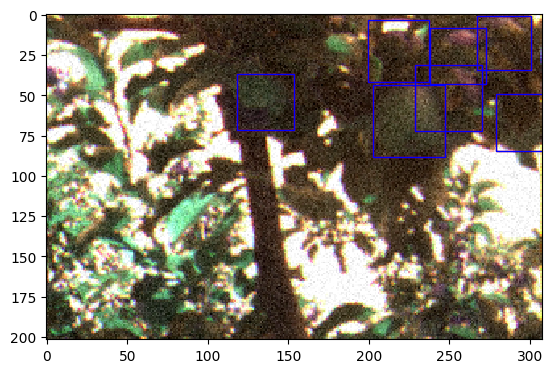

In [5]:
# Checking if preprocessing comlepted successfuly
num = 576
grid_size = (7,10)
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([test_set_coords[num]], grid_size, max_box_per_apple=1)
original_coords = split_origin(test_set_coords_tr)
plot_results(test_set_img[num], original_coords, original_coords)

In [9]:
# Load weights for model
model_w = load_model(
    r'C:\Users\mikolaj.martinek\Documents\Private\mgr_stage\calls22\model10-prost1.110-177.9033.h5',
    compile=False
)

weights = model_w.get_weights()

In [10]:
# Constants

# Define grid size
grid_size = (7,10)
# Define how many bboxes can be in one cell
bbox_per_cell = 1
# DEfine input shape
input_shape = (202, 308, 3)
# Define resized shape of image: optionally can be changed
new_size = (202,308)

# Create input
inputs = Input(shape=input_shape)
resize_layer = Resizing(new_size[0], new_size[1])(inputs)

# Define backbonne model
base_model = YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco",load_weights=True)

# Backbone layers freezing
n = 100  # Number of layers to freeze
for layer in base_model.layers[:n]:
    layer.trainable = False

# Checking freezing
for layer in base_model.layers:
    print(layer, layer.trainable)

# Checking layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# Select how many layers of backbone we will use
selected_layer = base_model.layers[117].output

# Create model with backbone: name vgg16 is reminder that previously vgg16 backbone was used
vgg16_truncated = Model(inputs=base_model.input, outputs=selected_layer)
vgg16 = vgg16_truncated(resize_layer)



x = Flatten()(vgg16)


# YOLO-like predictions  output layers
output_channels = bbox_per_cell * 4 
drop = Dropout(0.5)(x)
bbox_predictions = Dense(grid_size[0] * grid_size[1] * output_channels, activation='linear', name='bbox_predictions')(drop)
bbox_predictions = Reshape((grid_size[0], grid_size[1], bbox_per_cell, 4), name='bbox_predictions_f')(bbox_predictions)  # Reshape predictions


# YOLO-like predictions output layers
output_channels_conf = bbox_per_cell * 1
drop_pred = Dropout(0.5)(x)
confidence_scores = Dense(grid_size[0] * grid_size[1] * output_channels_conf, activation='sigmoid', name='confidence_scores')(drop_pred)
confidence_scores = Reshape((grid_size[0], grid_size[1], bbox_per_cell, 1), name='confidence_scores_f')(confidence_scores)

# Create model
model = Model(inputs=inputs, outputs=[bbox_predictions, confidence_scores])

# Model summary
model.summary()

# YOLO Loss function - bboxes
def bbox_loss(y_true, y_pred):
    # Weight constans
    lambda_coord = 5

    # y_true and y_pred
    true_xy = y_true[..., 0:2]
    true_w = y_true[..., 2:3]
    true_h = y_true[..., 3:4]
    true_prob = y_true[..., 4:5]
    
    pred_xy = y_pred[..., 0:2]
    pred_w = y_pred[..., 2:3]
    pred_h = y_pred[..., 3:4]
    
    obj_mask = tf.cast(tf.greater(true_prob, 0.5), dtype=tf.float32)  # 1 for cells with object, 0 for cells without object

    # Bbox loss
    coord_loss = tf.reduce_sum(tf.square(obj_mask*(true_xy - pred_xy))) + tf.reduce_sum(tf.square(obj_mask*(true_w - pred_w))) + tf.reduce_sum(tf.square(obj_mask*(true_h - pred_h)))
    
    # Total loss
    total_bbox_loss = lambda_coord * coord_loss 

    return total_bbox_loss

# YOLO Loss function - confidence
def conf_loss(y_true, y_pred):

    lambda_noobj = 0.5
    lambda_obj = 2

    true_prob = y_true[..., 3:4]
    pred_prob = y_pred[..., 0:1]

     # Confidence loss
    obj_mask = tf.cast(tf.greater(true_prob, 0.5), dtype=tf.float32)
    noobj_mask = 1 - obj_mask  # mask reversed

    obj_loss = tf.reduce_sum(tf.square(obj_mask*(true_prob-pred_prob)))
    noobj_loss = tf.reduce_sum(tf.square(noobj_mask*(true_prob-pred_prob)))   

    total_conf_loss = lambda_obj * obj_loss + lambda_noobj * noobj_loss

    return total_conf_loss


# Compile model
custom_optimizer = Adam(learning_rate=1e-4)
model.compile(loss=[bbox_loss, conf_loss], loss_weights=[1.0,1.0], optimizer=custom_optimizer, metrics=['accuracy'
                                                                                                            ])

# Define lr scheduler that makes lr smaller when there is no progress
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_delta=1e-4, 
                              min_lr=1e-10,
                              cooldown=3)

def scheduler(epoch, lr):
    if epoch < 60:
        return lr
    elif epoch == 60:
        lr = lr*0.1
        return lr
    elif epoch < 120:
        return lr
    else:
        return lr * (0.99 ** (epoch - 80))


# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='calls/model.{epoch:02d}-{val_loss:.4f}.h5'),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
]

model.set_weights(weights)

# Training
history_y1 = model.fit(
    train_set_img,  
    train_labels,   
    batch_size=8,
    epochs=600,
    verbose=2,
    shuffle=True,
    validation_data=(valid_set_img, valid_labels),  
    callbacks=my_callbacks
)

# Saving model
model.save('models/y6_model.h5')

<keras.src.engine.input_layer.InputLayer object at 0x000001EB6059B690> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001EB605DAE10> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001EAC41CBE10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001EAC4134F90> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001EAC4413990> False
<keras.src.layers.core.activation.Activation object at 0x000001EAC4459490> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001EB5F9C4C10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001EAC44A7BD0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001EAC448B290> False
<keras.src.layers.core.activation.Activation object at 0x000001EAC448B410> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001EAC44F0510> False
<keras.src.layers

KeyboardInterrupt: 

1/1 [==============================] - 1s 1s/step
[array([[[[[ 0.7352412 , -0.1120825 ,  1.5029961 ,  1.3862278 ]],

         [[ 0.16516903, -0.03509975,  1.1837407 ,  1.2760804 ]],

         [[ 0.46820113,  0.47312626,  1.1823909 ,  1.225981  ]],

         [[ 0.69240546,  0.46114922,  1.415072  ,  1.5039603 ]],

         [[ 0.92414564,  0.19213744,  0.6738318 ,  0.7845624 ]],

         [[ 0.6275839 ,  0.7543383 ,  1.0369374 ,  1.0179063 ]],

         [[ 0.55138165,  0.46114862,  0.9567015 ,  1.0892406 ]],

         [[ 0.6293758 ,  0.66124624,  1.1249186 ,  1.1791123 ]],

         [[ 0.49874184,  0.2293508 ,  1.0977857 ,  1.188924  ]],

         [[ 0.8061386 ,  0.40099958,  1.5411533 ,  1.5903895 ]]],


        [[[ 0.636314  ,  0.863089  ,  0.9327123 ,  1.0329082 ]],

         [[ 0.40314955,  0.5007774 ,  1.0454419 ,  1.1279995 ]],

         [[ 0.6455796 ,  0.59955776,  1.4517968 ,  1.5959903 ]],

         [[-0.02863319,  0.09545755,  1.0174502 ,  1.0175785 ]],

         [[ 0.70394295,

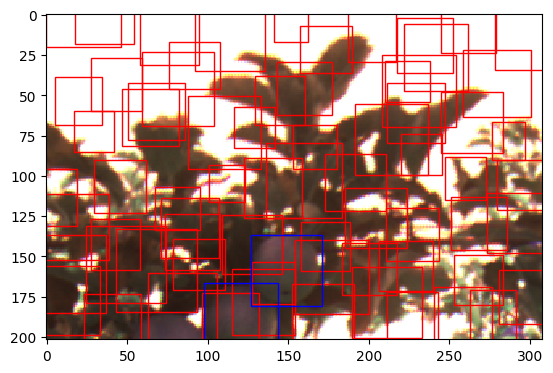

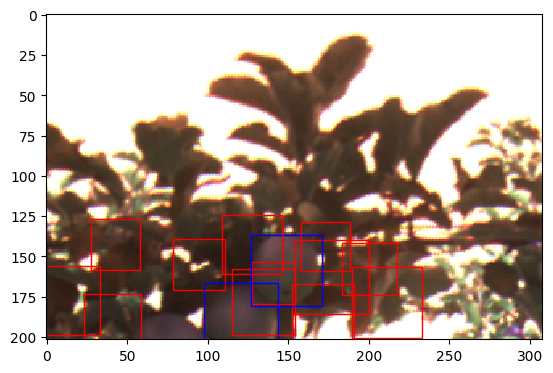

In [6]:
# Load a pre-trained model from a file path without compiling
model = load_model(
    r'<your model>',
    compile=False
)

# Define a specific sample number for processing
num = 567
# Define the grid size for the image
grid_size = (7,10)

# Reshape the input image for the model (adding an extra dimension)
input_image_reshaped = np.expand_dims(test_set_img[num], axis=0)
# Generate predictions from the model for the reshaped image
predictions=model.predict(input_image_reshaped)
print(predictions)

# Concatenate predictions along the last axis
predictions = np.concatenate((predictions[0], predictions[1]), axis = 4)

# Reverse transform and normalize the predictions
dt, probab = reverse_transform_data_and_normalization(predictions, grid_size)
# Reverse transform and normalize the coordinates for the test set
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([test_set_coords[num]], grid_size, max_box_per_apple=1)

# Apply threshold to the predictions and split them
prediction = apply_threshold_and_split_pred(dt, 0)
print("Predicted coords",prediction)
print("Predicted probabilities",probab)

# Prepare list for Non-Maximum Suppression (NMS)
before_nms = []
for list_ in prediction:
    for elem in list_:
        before_nms.append(elem)

# Apply NMS to filter predictions based on overlap and confidence threshold
after_nms = NMS(before_nms,0.7,0.3,probab[0])
# Extract coordinates from NMS output
only_pred_after_nms = []
for list_ in after_nms:
    only_pred_after_nms.append(list_[:-1])
print("Predicted coords after NMS",only_pred_after_nms)

# Split original coordinates for plotting
original_coords = split_origin(test_set_coords_tr)
# Plot results with predicted coordinates before NMS
plot_results(test_set_img[num], prediction, original_coords)
# Plot results with predicted coordinates after NMS
plot_results(test_set_img[num], only_pred_after_nms, original_coords)

1/1 [==============================] - 1s 667ms/step
[array([[[[[ 0.7996935 ,  0.6799977 ,  1.2594469 ,  1.3332963 ]],

         [[ 0.17366748,  0.40528736,  1.0438575 ,  1.1115166 ]],

         [[ 0.4328643 ,  0.76642925,  0.9633516 ,  0.98969865]],

         [[ 0.6169424 ,  0.34675425,  1.0383625 ,  1.1186664 ]],

         [[ 0.80810094,  0.84168124,  1.2017854 ,  1.3115529 ]],

         [[-0.01152155,  0.7490205 ,  1.2914345 ,  1.308108  ]],

         [[ 0.7312459 ,  0.40333715,  1.3008574 ,  1.4085108 ]],

         [[ 0.40286994,  0.5833212 ,  1.2582878 ,  1.3508643 ]],

         [[ 1.019319  ,  0.04830924,  1.3190136 ,  1.2797865 ]],

         [[ 0.5510615 ,  0.5861986 ,  1.0889193 ,  1.2386183 ]]],


        [[[ 0.64626473,  0.14327285,  1.0735455 ,  1.157697  ]],

         [[ 0.51602757,  0.7436633 ,  1.0441452 ,  1.1091355 ]],

         [[ 0.25553715,  0.33270267,  1.0984236 ,  1.173242  ]],

         [[ 0.22490023,  0.61311615,  1.3049698 ,  1.389924  ]],

         [[ 0.765039

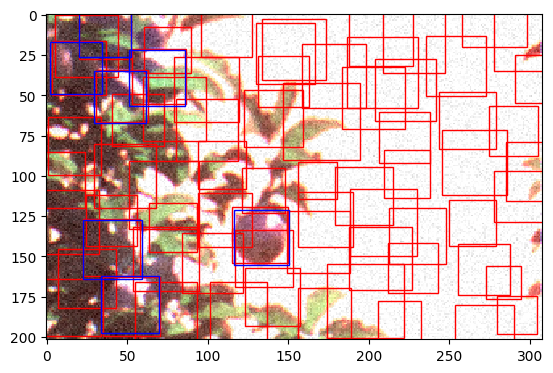

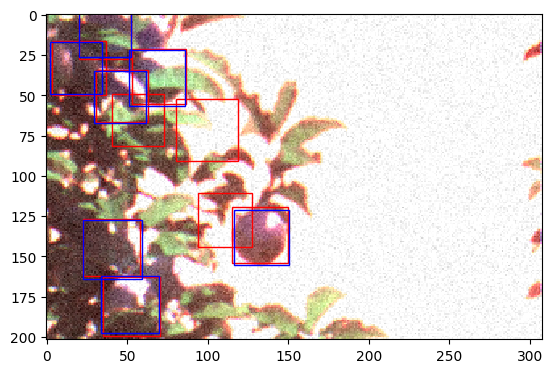

In [7]:

model = load_model(
    r'<your model>',
    compile=False
)

num = 6458
grid_size = (7,10)

input_image_reshaped = np.expand_dims(train_set_img[num], axis=0)
predictions=model.predict(input_image_reshaped)
print(predictions)

predictions = np.concatenate((predictions[0], predictions[1]), axis = 4)

dt, probab = reverse_transform_data_and_normalization(predictions, grid_size)
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([train_set_coords[num]], grid_size, max_box_per_apple=1)


prediction = apply_threshold_and_split_pred(dt, 0)
print("Predicted coords",prediction)
print("Predicted probabilities",probab)
print("Origin prob", train_set_prob[num])
before_nms = []
for list_ in prediction:
    for elem in list_:
        before_nms.append(elem)

after_nms = NMS(before_nms,0.7,0.5,probab[0])
only_pred_after_nms = []
for list_ in after_nms:
    only_pred_after_nms.append(list_[:-1])
print("Predicted coords after NMS",only_pred_after_nms)

original_coords = split_origin(test_set_coords_tr)
plot_results(train_set_img[num], prediction, original_coords)
plot_results(train_set_img[num], only_pred_after_nms, original_coords)